# Demonstrate MCMC exploration of posterior distribution of conic parameters

## Imports

We need to explictly add the path to the library since we haven't installed it yet.

In [1]:
import sys

In [2]:
sys.path.append("../src")
import confit
import numpy as np
import lmfit
from matplotlib import pyplot as plt
import seaborn as sns

## Test data

Symmetric arrangement of 7 points, which I then stretch and distort to make it more interesting.  Using fewer than 7 points is not recommended, although it is possible to ge spectacularly small residuals that way!

In [3]:
xpts, ypts = np.array([1, 2, 3, 4, 5, 6, 7]), np.array([0, 4, 6, 7, 6, 4, 0])
ypts += xpts
xpts *= 3

## Do the fitting

Fit of a general conic with `only_parabola=False` so that the eccentricity is allowed to vary.

In [22]:
result_p = confit.fit_conic_to_xy(xpts, ypts, only_parabola=True)
result_e = confit.fit_conic_to_xy(xpts, ypts, only_parabola=False)

Look at the results

In [23]:
result_e


There are some significant correlations between parameters, which can be better studied via MCMC, which we will do next

## Calculate posterior probability of parameters with emcee



In [17]:
emcee_kws = dict(
    steps=1000, burn=300, thin=20, is_weighted=False, progress=False, workers=16, nan_policy="omit",
)
emcee_params = result_e.params.copy()

In [18]:
result_emcee = lmfit.minimize(confit.residual, args=(xpts, ypts), method='emcee', params=emcee_params, **emcee_kws)

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 94.3165011   92.46770393  92.13891784  96.59790976  86.62821283
 105.69449177]


In [19]:
result_emcee

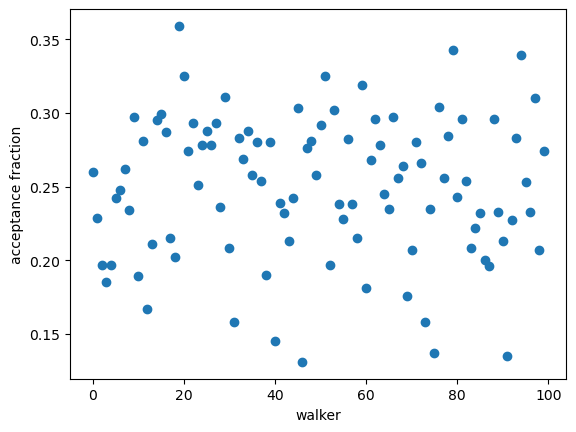

In [20]:
plt.plot(result_emcee.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

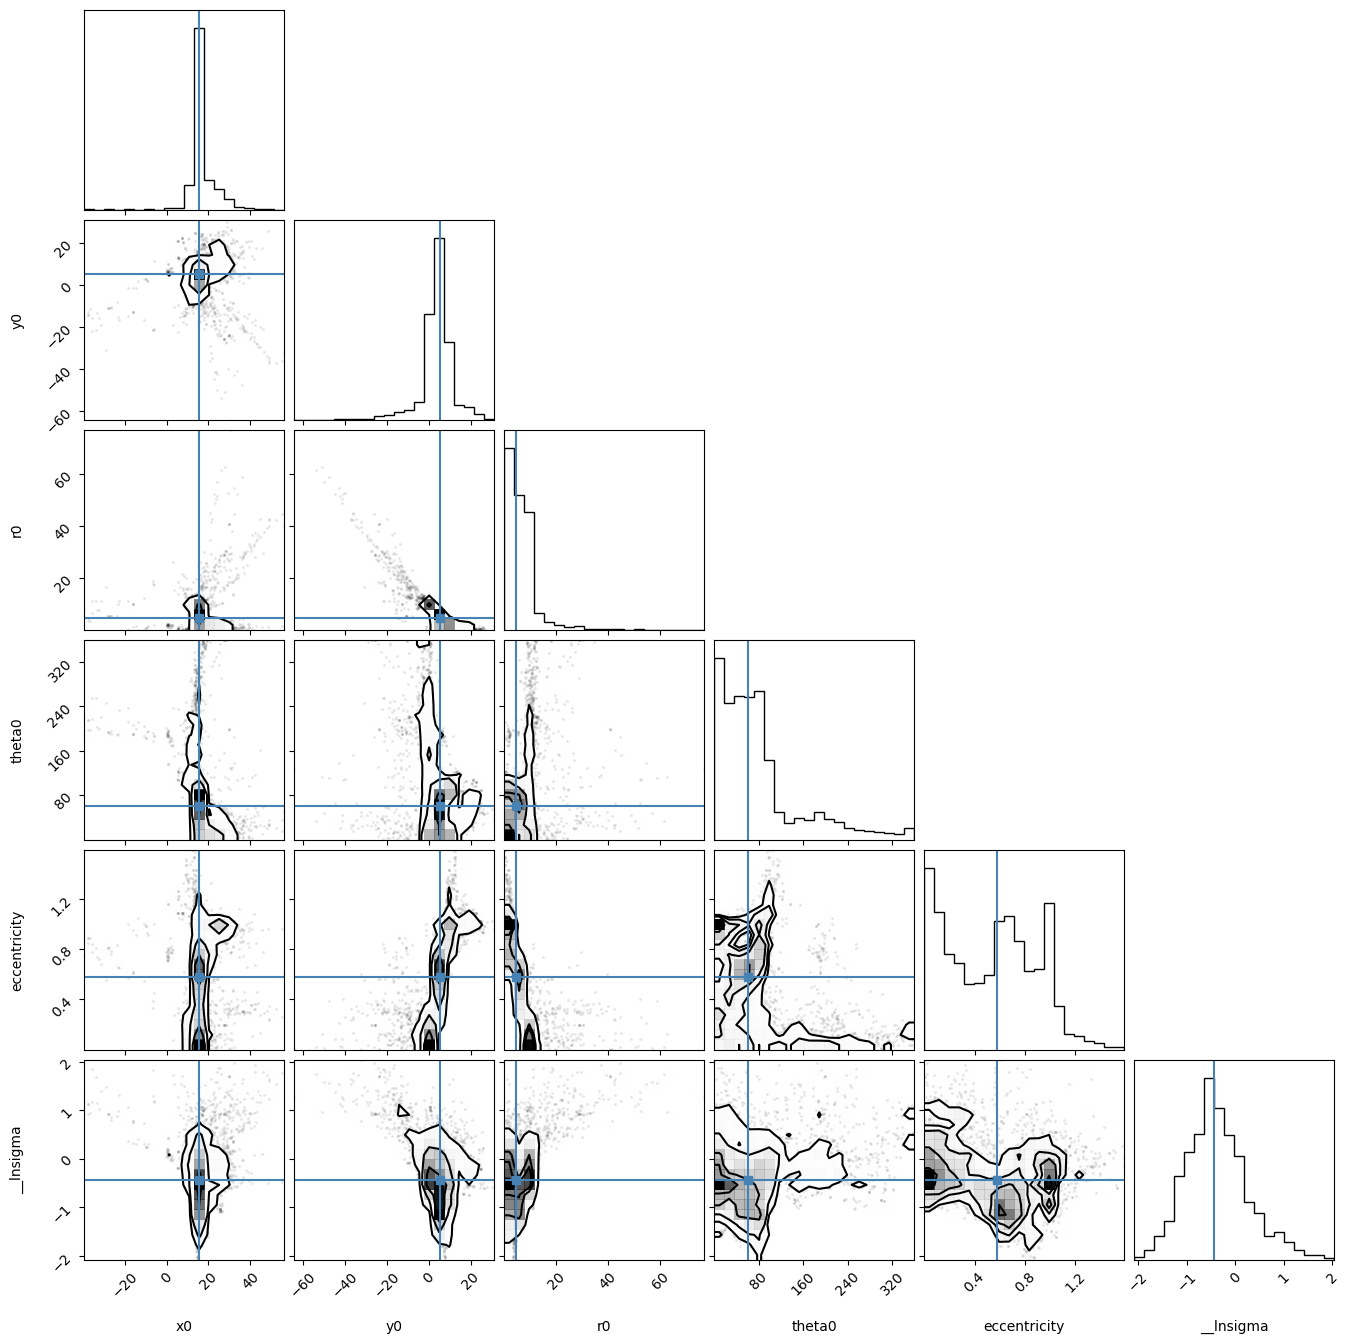

In [21]:
import corner

emcee_plot = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                           truths=list(result_emcee.params.valuesdict().values()))

In [24]:
result_emcee_p = lmfit.minimize(confit.residual, args=(xpts, ypts), method='emcee', params=result_p.params.copy(), **emcee_kws)

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [121.804246   117.74032596  95.38029515  82.30737941 133.99199853]


In [25]:
result_emcee_p 

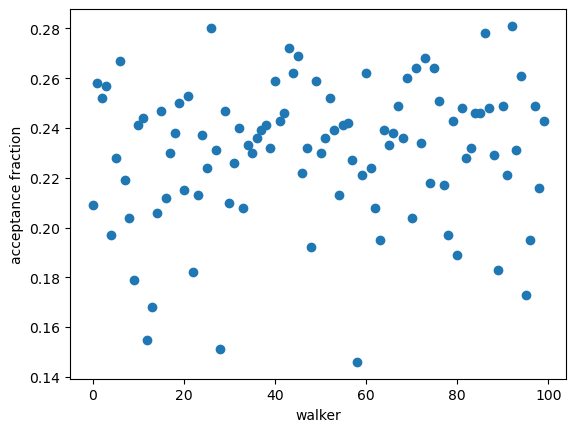

In [26]:
plt.plot(result_emcee_p.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

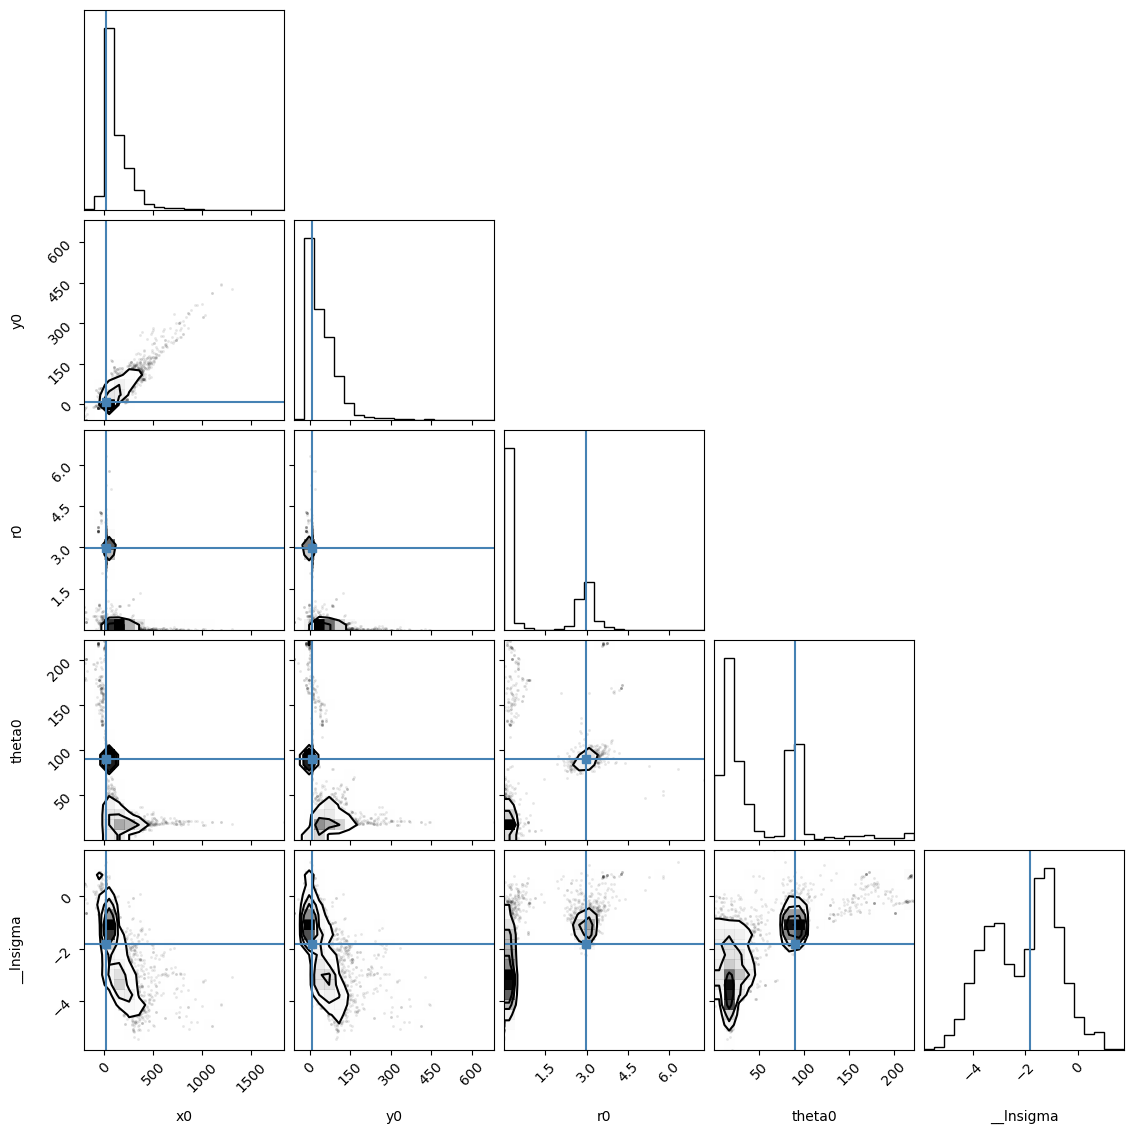

In [33]:
#truths = [result_emcee_p.params.valuesdict()[name] for name in result_emcee_p.var_names]
truths = [result_p.params.valuesdict()[name] for name in result_p.var_names] + [result_emcee_p.params.valuesdict()["__lnsigma"]]
emcee_plot_p = corner.corner(
    result_emcee_p.flatchain, labels=result_emcee_p.var_names, truths=truths,
)

## Plotting the best fit onto the data

In [73]:
best_xy = confit.XYconic(**result_p.params.valuesdict())
print(best_xy)

Conic section curve with focus at (13.960432334044226, 8.230286213583247), scale factor 2.9827089019390476, angle 90.18600416021702, and eccentricity 1.0.


/Users/will/Dropbox/confit/notebooks/../src/confit.py:102: RuntimeWarning: divide by zero encountered in true_divide
  self.r0


Get a list of dicts with the conic parameters from the MC chain

In [74]:
chain_pars = result_emcee_p.flatchain.drop(columns="__lnsigma").to_dict(orient="records")
len(chain_pars)

3500

Take every 35th row so we have 100 samples in total and get the xy curves for them all

In [75]:
chain_xy = [confit.XYconic(**row, eccentricity=1.0) for row in chain_pars[10::17]]

/Users/will/Dropbox/confit/notebooks/../src/confit.py:102: RuntimeWarning: divide by zero encountered in true_divide
  self.r0


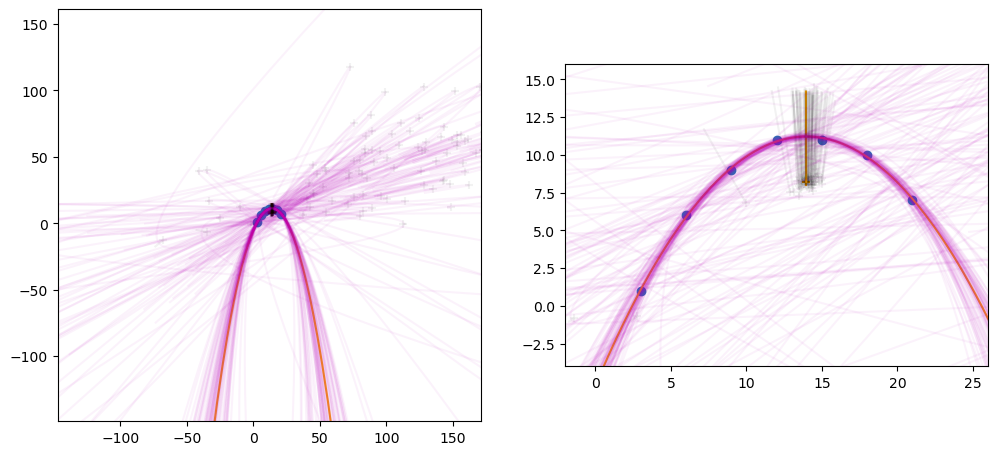

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax in axes:
    ax.scatter(xpts, ypts)

    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.05
    for xy in chain_xy:
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color="k", alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color="k", alpha=alpha)

    ax.set_aspect("equal")
margin = 150
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

In [86]:
best_xy = confit.XYconic(**result_e.params.valuesdict())
chain_pars = result_emcee.flatchain.drop(columns="__lnsigma").to_dict(orient="records")
chain_xy = [confit.XYconic(**row) for row in chain_pars[1::10]]

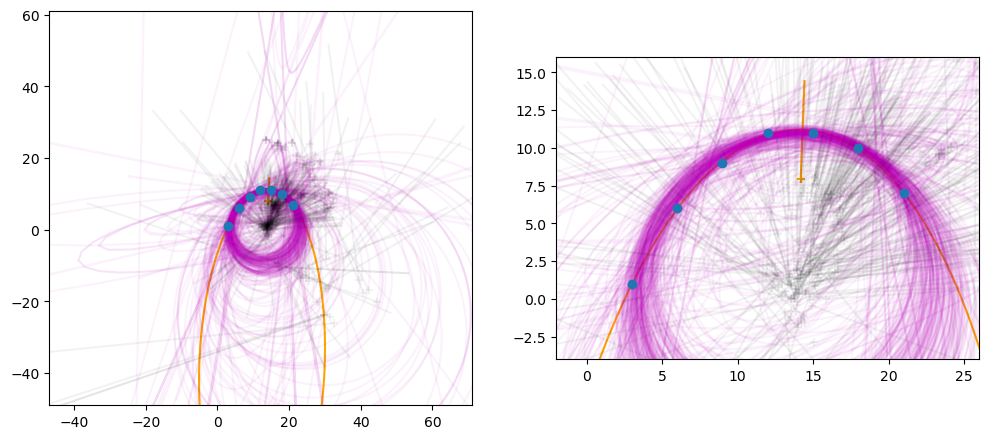

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax in axes:
    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.05
    for xy in chain_xy:
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color="k", alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color="k", alpha=alpha)
    ax.scatter(xpts, ypts, zorder=1000)
    ax.set_aspect("equal")
    
margin = 50
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

## Try and put limits on parameters to avoid the "unreasonable" global minima

In the parabola case, we have a whole bunch of supposedly valid fits that have small value of `r0` (less than 1) coupled with large values of `x0` and `y0` (more than 30) and `theta0` angles around 30 deg. In the figure above, they can be seen to all be well separated from the "good" fits.  So if we put bounds on `r0` we could possibly eliminate them. 

In [97]:
new_params = result_p.params.copy()
rscale = new_params["r0"].value
new_params["r0"].set(min=rscale/2, max=rscale*2)
new_params

name,value,standard error,relative error,initial value,min,max,vary
x0,13.9604323,0.31535709,(2.26%),12.0,-inf,inf,True
y0,8.23028621,0.21719266,(2.64%),9.0,-inf,inf,True
r0,2.98270890,0.15103907,(5.06%),4.279303547652316,1.49135445,5.96541780,True
theta0,90.1860042,2.64713202,(2.94%),93.41881035763075,0.00000000,360.000000,True
eccentricity,1.00000000,0.00000000,(0.00%),1.0,0.00000000,inf,False


In [98]:
result_emcee_pp = lmfit.minimize(confit.residual, args=(xpts, ypts), method='emcee', params=new_params, **emcee_kws)

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [45.20128519 39.42030879 43.14988116 46.64638297 96.37076625]


In [99]:
result_emcee_pp

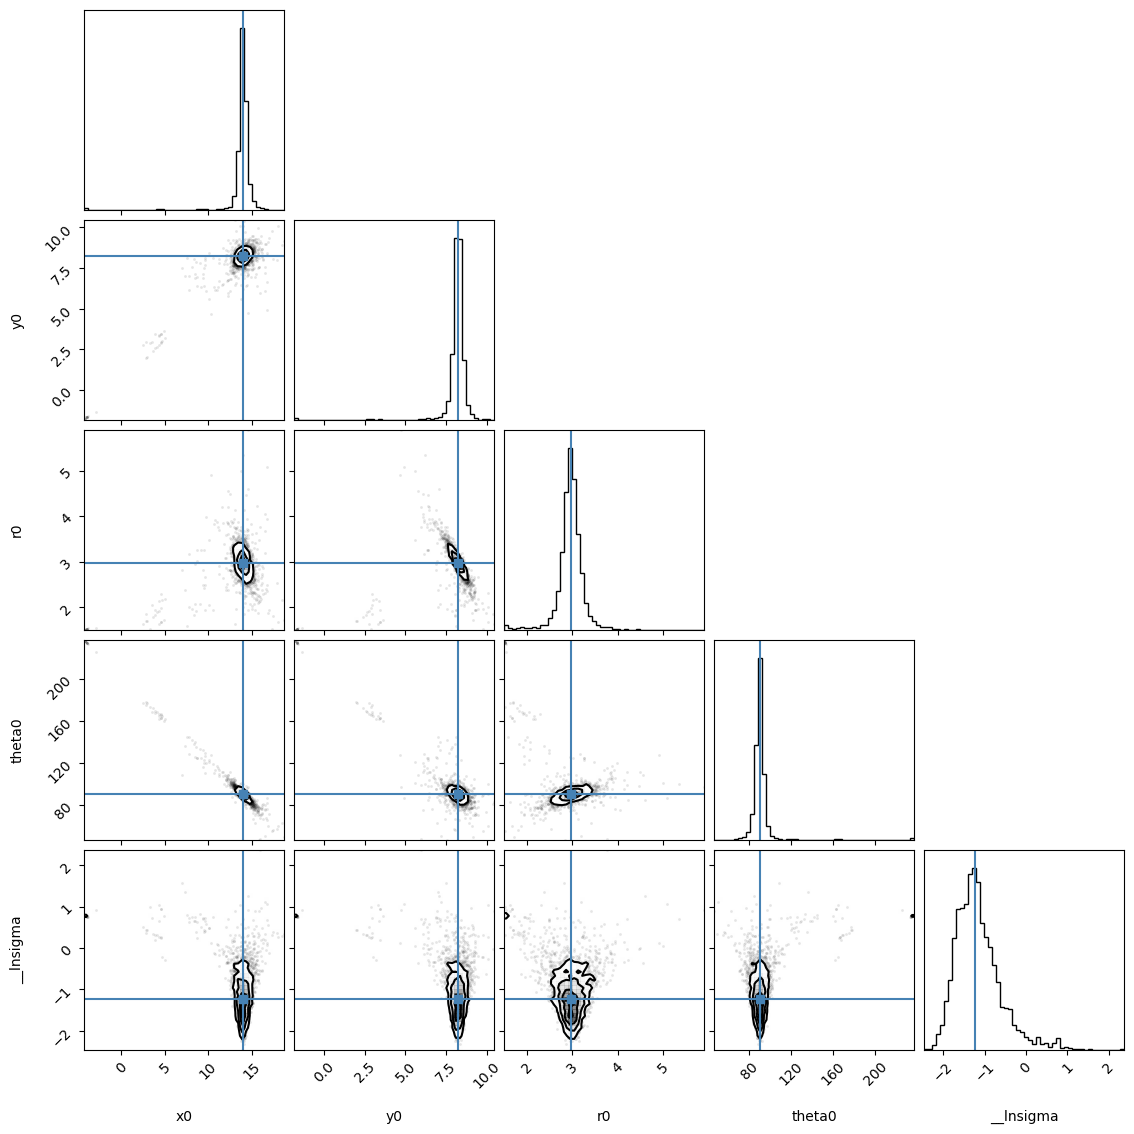

In [106]:
truths = [result_emcee_pp.params.valuesdict()[name] for name in result_emcee_pp.var_names]
emcee_plot_p = corner.corner(
    result_emcee_pp.flatchain, labels=result_emcee_pp.var_names, truths=truths, bins=50,
)

In [102]:
best_xy = confit.XYconic(**result_p.params.valuesdict())
chain_pars = result_emcee_pp.flatchain.drop(columns="__lnsigma").to_dict(orient="records")
chain_xy = [confit.XYconic(**row, eccentricity=1.0) for row in chain_pars[1::10]]

/Users/will/Dropbox/confit/notebooks/../src/confit.py:102: RuntimeWarning: divide by zero encountered in true_divide
  self.r0
/Users/will/Dropbox/confit/notebooks/../src/confit.py:102: RuntimeWarning: divide by zero encountered in true_divide
  self.r0


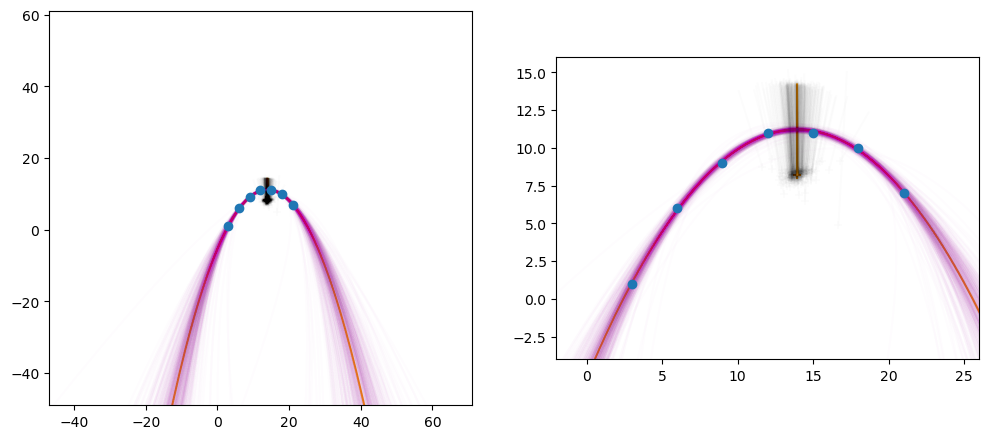

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax in axes:
    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.01
    for xy in chain_xy:
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color="k", alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color="k", alpha=alpha)
    ax.scatter(xpts, ypts, zorder=1000)
    ax.set_aspect("equal")
    
margin = 50
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

In [105]:
corner.corner?

Signature:
corner.corner(
    data,
    bins=20,
    *,
    range=None,
    weights=None,
    color='k',
    hist_bin_factor=1,
    smooth=None,
    smooth1d=None,
    labels=None,
    label_kwargs=None,
    titles=None,
    show_titles=False,
    title_fmt='.2f',
    title_kwargs=None,
    truths=None,
    truth_color='#4682b4',
    scale_hist=False,
    quantiles=None,
    verbose=False,
    fig=None,
    max_n_ticks=5,
    top_ticks=False,
    use_math_text=False,
    reverse=False,
    labelpad=0.0,
    hist_kwargs=None,
    group='posterior',
    var_names=None,
    filter_vars=None,
    coords=None,
    divergences=False,
    divergences_kwargs=None,
    labeller=None,
    **hist2d_kwargs,
)
Docstring:
Make a *sick* corner plot showing the projections of a data set in a
multi-dimensional space. kwargs are passed to hist2d() or used for
`matplotlib` styling.

Parameters
----------
data : obj
    Any object that can be converted to an ``arviz.InferenceData`` object.
    Refer to do